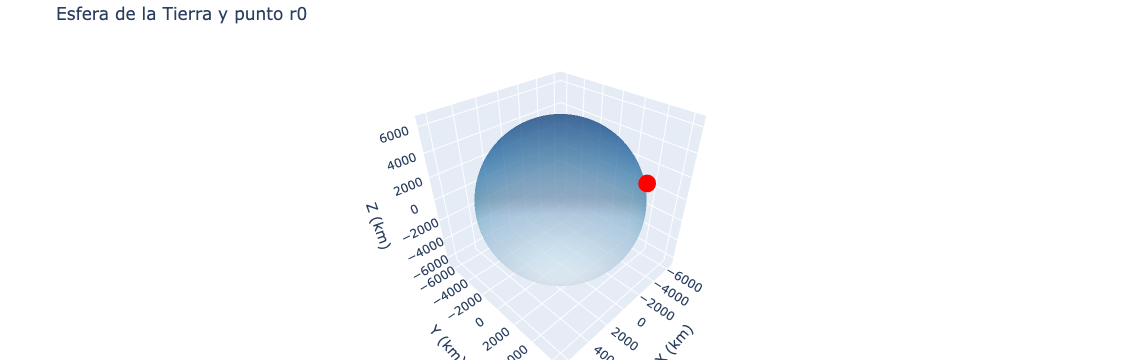

In [57]:
import numpy as np
import plotly.graph_objects as go
import astropy.units as u

# Radio de la Tierra en km
R = Earth.R.to(u.km).value

# Punto r0
r0 = np.array([-2384.46, 5729.01, 3050.46]) * u.km

# Generar los puntos de la esfera (Tierra)
phi = np.linspace(0, np.pi, 100)  # Ángulo azimutal
theta = np.linspace(0, 2 * np.pi, 100)  # Ángulo polar
phi, theta = np.meshgrid(phi, theta)

# Coordenadas paramétricas de la esfera
x = R * np.sin(phi) * np.cos(theta)
y = R * np.sin(phi) * np.sin(theta)
z = R * np.cos(phi)

# Crear la figura con Plotly
fig = go.Figure()

# Dibujar la esfera
fig.add_trace(go.Surface(
    x=x, y=y, z=z,
    colorscale='Blues',
    opacity=0.5,
    showscale=False
))

# Dibujar el punto r0
fig.add_trace(go.Scatter3d(
    x=[r0[0].value], y=[r0[1].value], z=[r0[2].value],
    mode='markers',
    marker=dict(size=10, color='red'),
    name=f'Punto r0 {r0}'
))

# Configurar el gráfico
fig.update_layout(
    scene=dict(
        xaxis_title='X (km)',
        yaxis_title='Y (km)',
        zaxis_title='Z (km)',
        aspectmode='cube'
    ),
    title="Esfera de la Tierra y punto r0",
    margin=dict(l=0, r=0, b=0, t=40)
)

# Mostrar el gráfico
fig.show()

In [56]:
import numpy as np
import astropy.units as u

# Coordenadas cartesianas de r0
x, y, z = np.array([-2384.46, 5729.01, 3050.46]) * u.km

# 1. Calcular el radio (r)
r = np.sqrt(x**2 + y**2 + z**2)

# 2. Calcular el ángulo polar (theta)
theta = np.arccos(z / r)

# 3. Calcular el ángulo azimutal (phi)
phi = np.arctan2(y, x)

# Mostrar resultados
print(f"Coordenadas cartesianas: ({x}, {y}, {z})")
print(f"Radio r: {r}")
print(f"Ángulo polar theta (en radianes): {theta}")
print(f"Ángulo azimutal phi (en radianes): {phi}")

# Si deseas los ángulos en grados:
theta_deg = np.degrees(theta)
phi_deg = np.degrees(phi)

print(f"Ángulo polar theta (en grados): {theta_deg}")
print(f"Ángulo azimutal phi (en grados): {phi_deg}")


Coordenadas cartesianas: (-2384.46 km, 5729.01 km, 3050.46 km)
Radio r: 6914.6591588667625 km
Ángulo polar theta (en radianes): 1.113907259518469 rad
Ángulo azimutal phi (en radianes): 1.9651965969317768 rad
Ángulo polar theta (en grados): 63.822184739391965 deg
Ángulo azimutal phi (en grados): 112.5974709176628 deg


In [ ]:
from matplotlib import pyplot as plt
import numpy as np

from astropy.coordinates import solar_system_ephemeris
from astropy.time import Time, TimeDelta
from astropy import units as u

from poliastro.bodies import Earth, Moon
from poliastro.constants import rho0_earth, H0_earth

from poliastro.core.elements import rv2coe
from poliastro.core.perturbations import (
    atmospheric_drag_exponential,
    third_body,
    J2_perturbation,
)
from poliastro.core.propagation import func_twobody
from poliastro.ephem import build_ephem_interpolant
from poliastro.plotting import OrbitPlotter3D
from poliastro.twobody import Orbit
from poliastro.twobody.propagation import CowellPropagator
from poliastro.twobody.sampling import EpochsArray


In [5]:
# More info: https://plotly.com/python/renderers/
import plotly.io as pio

pio.renderers.default = "plotly_mimetype+notebook_connected"

In [9]:
R = Earth.R.to(u.km).value
k = Earth.k.to(u.km**3 / u.s**2).value # constante gravitacional

In [22]:
k

398600.44180000003

## Constantes y valores

k es la constante de gravitacion universal --> Lo estamos convirtiendo a unidades de interes.

$r_0$ representan las coordenadas cartesianas en km de la posición inicial del satelite

$v_0$ representan las velocidades en un sistema cartesiano

$tofs$ Representa un conjunto de instantes de tiempo en los cuales se calcularán posiciones futuras del satélite.

- Genera 2000 valores de tiempo entre 0 y 48 horas.
- 48.0 * u.h usa astropy.units para definir el tiempo en horas.
- TimeDelta(...) convierte la matriz de tiempos en un formato adecuado para poliastro.


In [61]:
r0 = np.array([-2384.46, 5729.01, 3050.46]) * u.km
v0 = np.array([-7.36138, -2.98997, 1.64354]) * u.km / u.s

orbit = Orbit.from_vectors(Earth, r0, v0)
tofs = TimeDelta(np.linspace(0, 500 * u.h, num=2000))


In [41]:
print("Orbit:", orbit)

Orbit: 6678 x 9440 km x 28.0 deg (GCRS) orbit around Earth (♁) at epoch J2000.000 (TT)


## Contrucción de la órbita
- 6678 x 9440: El primer término representa el perigeo y el segundo el apogeo.
- 28deg: Inclinación de la orbita respecto al plano ecuatorial de la tierra (GCRS: Geocentriccelestial reference system)

Estos términos nos hablan de la característica elíptica de la orbita
- Orbit around Earth: Indica que la órbita es alrededor de la tierra

- Epoch hace referencia a un momento específico en el tiempo en el que se calculan las condiciones de la órbita.
J2000.000 es una referencia de tiempo estándar en astronomía que corresponde al 1 de enero de 2000 a las 12:00 TT (Tiempo Terrestre).


## Ecuación diferencial y propagacion

- f es una función que describe la ecuación diferencial de la órbita en función del tiempo (t0) estado de la órbita (state) y la constante de gravitación k.

- func_twobody: Recibe el tiempo inicial, el estado y k. du_kep calcula las aceleraciónes de una orbita kepleriana sin perturbaciones

- ax, ay, az: Son las aceleraciones debido a J2.

- du_kep + du_ad: Finalmente, la función devuelve la suma de las aceleraciones debido a la gravitación mutua (de func_twobody) y las aceleraciones perturbativas debido al efecto. Este es el cambio total en el estado orbital del satélite.

In [62]:
def f(t0, state, k):
    du_kep = func_twobody(t0, state, k)
    ax, ay, az = J2_perturbation(
        t0, state, k, J2=Earth.J2.value, R=Earth.R.to(u.km).value
    )
    du_ad = np.array([0, 0, 0, ax, ay, az])

    return du_kep + du_ad


In [63]:
rr, vv = orbit.to_ephem(
    EpochsArray(orbit.epoch + tofs, method=CowellPropagator(f=f)),
).rv()

raans = [
    rv2coe(k, r, v)[3]
    for r, v in zip(rr.to_value(u.km), vv.to_value(u.km / u.s))
]

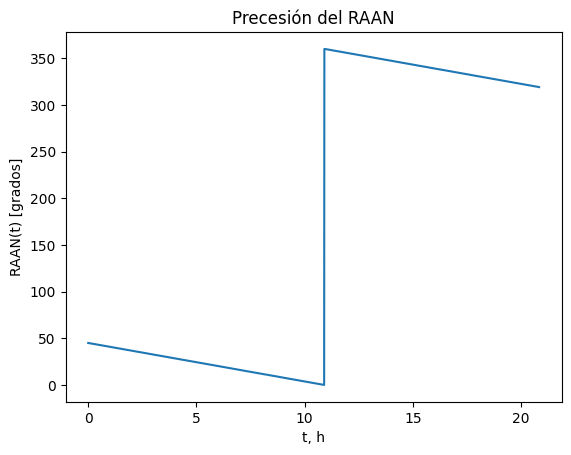

In [64]:
raans_deg = np.degrees(raans)  # Convertir de radianes a grados

# Graficar
plt.title("Precesión del RAAN")
plt.ylabel("RAAN(t) [grados]")  # Cambiar a grados
plt.xlabel("t, h")
plt.plot(tofs.value, raans_deg)  # Graficar RAAN en grados
plt.show()

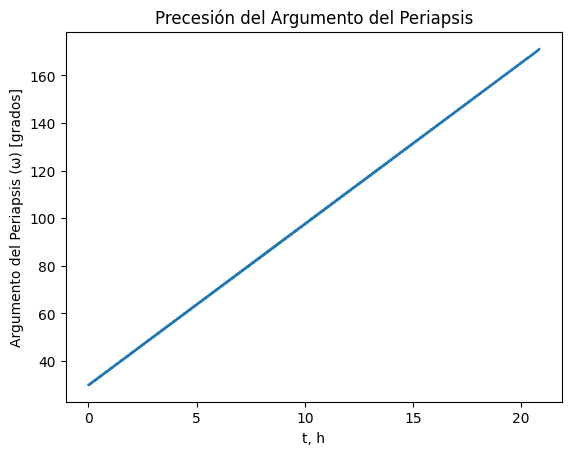

In [65]:
omega = [
    rv2coe(k, r, v)[4]  # Extraer el argumento del periapsis
    for r, v in zip(rr.to_value(u.km), vv.to_value(u.km / u.s))
]

omega_deg = np.degrees(omega)  # Convertir de radianes a grados

# Graficar
plt.title("Precesión del Argumento del Periapsis")
plt.ylabel("Argumento del Periapsis (ω) [grados]")  # Etiqueta para el eje Y
plt.xlabel("t, h")  # Etiqueta para el eje X
plt.plot(tofs.value, omega_deg)  # Graficar el argumento del periapsis en grados
plt.show()

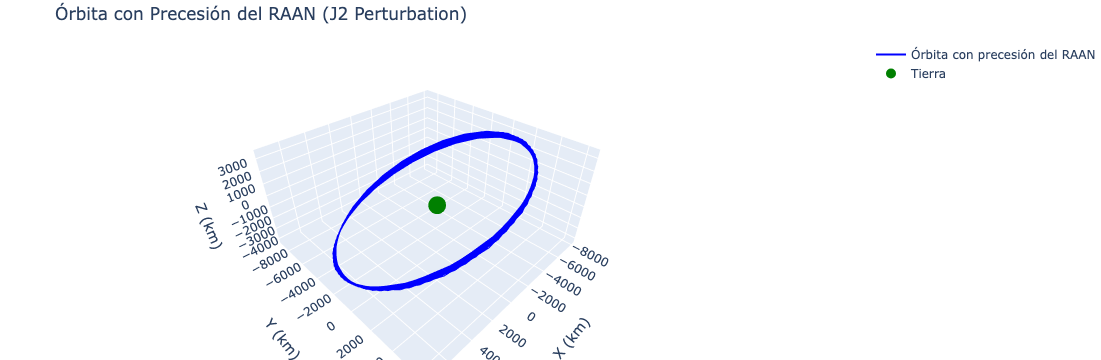

In [58]:
# Definir la órbita inicial
r0 = np.array([-2384.46, 5729.01, 3050.46]) * u.km
v0 = np.array([-7.36138, -2.98997, 1.64354]) * u.km / u.s
orbit = Orbit.from_vectors(Earth, r0, v0)

# Intervalo de tiempo para propagar (48 horas)
tofs = TimeDelta(np.linspace(0, 48 * u.h, num=500))

# Función de perturbación con J2
def f(t0, state, k):
    du_kep = func_twobody(t0, state, k)
    ax, ay, az = J2_perturbation(
        t0, state, k, J2=Earth.J2.value, R=Earth.R.to(u.km).value
    )
    du_ad = np.array([0, 0, 0, ax, ay, az])
    return du_kep + du_ad

# Propagar la órbita con perturbación
rr, vv = orbit.to_ephem(
    EpochsArray(orbit.epoch + tofs, method=CowellPropagator(f=f))
).rv()

# Extraer coordenadas X, Y, Z
x, y, z = rr[:, 0].to_value(u.km), rr[:, 1].to_value(u.km), rr[:, 2].to_value(u.km)

# Crear gráfico 3D con Plotly
fig = go.Figure()

# Agregar la trayectoria orbital
fig.add_trace(go.Scatter3d(
    x=x, y=y, z=z,
    mode='lines',
    line=dict(color='blue', width=2),
    name="Órbita con precesión del RAAN"
))

# Agregar la Tierra
fig.add_trace(go.Scatter3d(
    x=[0], y=[0], z=[0],
    mode='markers',
    marker=dict(size=10, color='green'),
    name="Tierra"
))

# Configuración del gráfico
fig.update_layout(
    title="Órbita con Precesión del RAAN (J2 Perturbation)",
    scene=dict(
        xaxis_title='X (km)',
        yaxis_title='Y (km)',
        zaxis_title='Z (km)',
        aspectmode="auto"
    ),
    margin=dict(l=0, r=0, b=0, t=40)
)

fig.show()


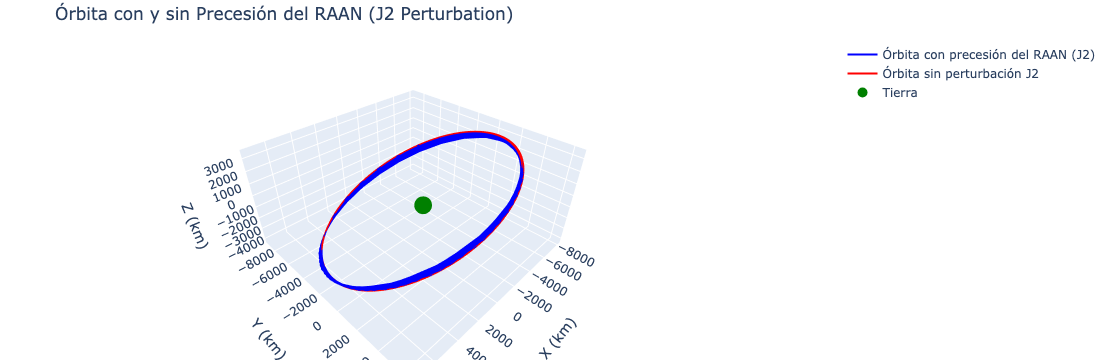

In [30]:
import numpy as np
import plotly.graph_objects as go
from astropy import units as u
from astropy.time import Time, TimeDelta

from poliastro.bodies import Earth
from poliastro.twobody import Orbit
from poliastro.core.perturbations import J2_perturbation
from poliastro.core.propagation import func_twobody
from poliastro.twobody.propagation import CowellPropagator
from poliastro.twobody.sampling import EpochsArray

# Definir la órbita inicial
r0 = np.array([-2384.46, 5729.01, 3050.46]) * u.km
v0 = np.array([-7.36138, -2.98997, 1.64354]) * u.km / u.s
orbit = Orbit.from_vectors(Earth, r0, v0)

# Intervalo de tiempo para propagar (48 horas)
tofs = TimeDelta(np.linspace(0, 48 * u.h, num=500))

# Función de perturbación con J2
def f(t0, state, k):
    du_kep = func_twobody(t0, state, k)
    ax, ay, az = J2_perturbation(
        t0, state, k, J2=Earth.J2.value, R=Earth.R.to(u.km).value
    )
    du_ad = np.array([0, 0, 0, ax, ay, az])
    return du_kep + du_ad

# Propagar la órbita con perturbación J2
rr_j2, vv_j2 = orbit.to_ephem(
    EpochsArray(orbit.epoch + tofs, method=CowellPropagator(f=f))
).rv()

# Propagar la órbita sin perturbación J2 (usando solo la gravitación de dos cuerpos)
def f_no_j2(t0, state, k):
    return func_twobody(t0, state, k)  # Solo la gravitación de dos cuerpos

# Propagar la órbita sin perturbación J2
rr_no_j2, vv_no_j2 = orbit.to_ephem(
    EpochsArray(orbit.epoch + tofs, method=CowellPropagator(f=f_no_j2))
).rv()

# Extraer coordenadas X, Y, Z para ambas órbitas
x_j2, y_j2, z_j2 = rr_j2[:, 0].to_value(u.km), rr_j2[:, 1].to_value(u.km), rr_j2[:, 2].to_value(u.km)
x_no_j2, y_no_j2, z_no_j2 = rr_no_j2[:, 0].to_value(u.km), rr_no_j2[:, 1].to_value(u.km), rr_no_j2[:, 2].to_value(u.km)

# Crear gráfico 3D con Plotly
fig = go.Figure()

# Agregar la trayectoria orbital con perturbación J2
fig.add_trace(go.Scatter3d(
    x=x_j2, y=y_j2, z=z_j2,
    mode='lines',
    line=dict(color='blue', width=2),
    name="Órbita con precesión del RAAN (J2)"
))

# Agregar la trayectoria orbital sin perturbación J2
fig.add_trace(go.Scatter3d(
    x=x_no_j2, y=y_no_j2, z=z_no_j2,
    mode='lines',
    line=dict(color='red', width=2),
    name="Órbita sin perturbación J2"
))

# Agregar la Tierra
fig.add_trace(go.Scatter3d(
    x=[0], y=[0], z=[0],
    mode='markers',
    marker=dict(size=10, color='green'),
    name="Tierra"
))

# Configuración del gráfico
fig.update_layout(
    title="Órbita con y sin Precesión del RAAN (J2 Perturbation)",
    scene=dict(
        xaxis_title='X (km)',
        yaxis_title='Y (km)',
        zaxis_title='Z (km)',
        aspectmode="auto"
    ),
    margin=dict(l=0, r=0, b=0, t=40)
)

fig.show()
